# COMPROBACIONES PREVIAS

In [1]:
import os, sys, torch, subprocess, json
print("PY:", sys.executable)
print("CWD:", os.getcwd())
print("torch:", torch.__version__, " HIP:", getattr(torch.version, "hip", None), " CUDA:", getattr(torch.version, "cuda", None))
print("GPU? ", torch.cuda.is_available())

# ¿Existen los dispositivos GPU?
print("\n/dev/kfd exists?", os.path.exists("/dev/kfd"))
print("/dev/dri/renderD128 exists?", os.path.exists("/dev/dri/renderD128"))

# ¿Estoy en el venv correcto?
print("\nsite-packages:", next(p for p in sys.path if p.endswith("site-packages")))


PY: /opt/venv/bin/python
CWD: /workspace/BERTolto/notebooks_BERTolto
torch: 2.7.1+rocm7.0.0.git698b58a9  HIP: 7.0.51831-a3e329ad8  CUDA: None
GPU?  True

/dev/kfd exists? True
/dev/dri/renderD128 exists? True

site-packages: /opt/venv/lib/python3.12/site-packages


In [2]:
import torch, os, transformers
print("GPU?", torch.cuda.is_available(), getattr(torch.version, "hip", None))
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0))
print("HF_HOME:", os.environ.get("HF_HOME"))

/opt/venv/lib/python3.12/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


GPU? True 7.0.51831-a3e329ad8
AMD Radeon RX 7800 XT
HF_HOME: /workspace/BERTolto/.hf_home


# --- Bootstrap mínimo para entorno local / Docker ROCm ---

In [3]:
# === BOOTSTRAP (actualizado con versionado limpio) ===
import os, sys, time
from pathlib import Path

# 1) Detecta entorno y fija PROJECT_ROOT
if Path("/workspace/BERTolto").exists():
    PROJECT_ROOT = Path("/workspace/BERTolto")   # dentro del contenedor
else:
    PROJECT_ROOT = Path("/home/diego/BERTolto")  # host Ubuntu (ajusta si cambias usuario)

print("PROJECT_ROOT:", PROJECT_ROOT)

if Path("/workspace/BERTolto").exists():
    DEST = Path("/workspace/BERTolto")
else:
    DEST = Path("/home/diego/BERTolto")
print("DEST:", DEST)

# 2) Rutas clave del repo
SRC_DIR   = PROJECT_ROOT / "src"
BASE_ARTI = SRC_DIR / "artifacts" / "hf_distilroberta"   # dataset/ y tokenizer/ viven aquí
TMP_DIR   = PROJECT_ROOT / "tmp"                         # temporal local si lo necesitas

# 2.1) RUN_ID y versionado de salidas
RUN_ID   = time.strftime("%Y%m%d-%H%M%S")
CKPT_ROOT = Path("/checkpoints")                         # volumen persistente montado por Docker

#from datetime import datetime
#RUN_TAG = datetime.now().strftime("%Y%m%d-%H%M%S")  # o algo como "iter01_github"
#OUT_DIR = f"/checkpoints/runs/{RUN_TAG}"
#SAVE_DIR = f"/checkpoints/models/{RUN_TAG}"

OUT_DIR   = CKPT_ROOT / f"run_distilroberta_{RUN_ID}"    # checkpoints del Trainer
SAVE_DIR  = CKPT_ROOT / f"model_distilroberta_ft_{RUN_ID}"  # modelo final + threshold

# (Opcional) punteros "latest" para encontrar fácilmente el último run
LATEST_OUT  = CKPT_ROOT / "run_distilroberta_latest"
LATEST_SAVE = CKPT_ROOT / "model_distilroberta_ft_latest"

# 3) HF cache: UNA única ubicación y 3 variables apuntando al mismo sitio
def _is_writable(p: Path) -> bool:
    try:
        p.mkdir(parents=True, exist_ok=True)
        t = p / ".writetest"
        t.write_text("ok", encoding="utf-8")
        t.unlink(missing_ok=True)
        return True
    except Exception:
        return False

# Preferimos una cache dentro del proyecto (evita permisos raros)
HF_CACHE = (PROJECT_ROOT / ".cache" / "huggingface").resolve()
if not _is_writable(HF_CACHE):
    # Fallback: si por lo que sea no es escribible, usa el HOME del contenedor/host
    HF_CACHE = (Path.home() / ".cache" / "huggingface").resolve()

os.environ["HF_HOME"] = str(HF_CACHE)
os.environ["HUGGINGFACE_HUB_CACHE"] = str(HF_CACHE)
os.environ["TRANSFORMERS_CACHE"] = str(HF_CACHE / "hub")
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["HF_HUB_DISABLE_TELEMETRY"] = "1"

# Crear carpetas necesarias
for p in [OUT_DIR, SAVE_DIR, TMP_DIR, HF_CACHE, HF_CACHE / "hub"]:
    p.mkdir(parents=True, exist_ok=True)

print("HF_HOME               =", os.environ["HF_HOME"])
print("HUGGINGFACE_HUB_CACHE =", os.environ["HUGGINGFACE_HUB_CACHE"])
print("TRANSFORMERS_CACHE    =", os.environ["TRANSFORMERS_CACHE"])
print("OUT_DIR:", OUT_DIR)
print("SAVE_DIR:", SAVE_DIR)

# 4) Asegurar que 'src/' está en el path
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

# 5) Verificaciones rápidas de artifacts
assert (BASE_ARTI / "dataset").exists(), f"Falta dataset en {BASE_ARTI/'dataset'}"
assert (BASE_ARTI / "tokenizer").exists(), f"Falta tokenizer en {BASE_ARTI/'tokenizer'}"
print("Artifacts OK:", BASE_ARTI)

# 6) (Opcional) refrescar punteros "latest" a este RUN_ID
try:
    for link, target in [(LATEST_OUT, OUT_DIR), (LATEST_SAVE, SAVE_DIR)]:
        if link.exists() or link.is_symlink():
            link.unlink()
        link.symlink_to(target, target_is_directory=True)
    print("Punteros 'latest' actualizados.")
except Exception as e:
    print("No se pudieron crear symlinks 'latest' (no crítico):", e)


PROJECT_ROOT: /workspace/BERTolto
DEST: /workspace/BERTolto
HF_HOME               = /workspace/BERTolto/.cache/huggingface
HUGGINGFACE_HUB_CACHE = /workspace/BERTolto/.cache/huggingface
TRANSFORMERS_CACHE    = /workspace/BERTolto/.cache/huggingface/hub
OUT_DIR: /checkpoints/run_distilroberta_20251030-200801
SAVE_DIR: /checkpoints/model_distilroberta_ft_20251030-200801
Artifacts OK: /workspace/BERTolto/src/artifacts/hf_distilroberta
Punteros 'latest' actualizados.


In [4]:
# (Local) Repo ya presente: no clonamos ni hacemos pull aquí.
# Usamos DEST definido en la celda Bootstrap.
from pathlib import Path

assert 'DEST' in globals(), "Asegúrate de ejecutar primero la celda Bootstrap que define DEST."
assert (DEST / "src").exists(), f"No se encontró src/ en {DEST}. Revisa tu ruta de trabajo o el montaje del volumen."

print("Repo listo en:", DEST)

Repo listo en: /workspace/BERTolto


# === Visualización: helpers + callback en vivo === (Métricas)
Define un callback que escucha los logs del Trainer y dibuja loss y F1 de validación a medida que avanza. 

In [5]:
import json, os, math
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from transformers import TrainerCallback

plt.rcParams.update({"figure.figsize": (6,4), "axes.grid": True})

class LivePlotCallback(TrainerCallback):
    """
    Dibuja durante el entrenamiento:
      - training_loss (de logs)
      - métrica de validación por epoch (macro_f1 o la que elijas)
    """
    def __init__(self, key="eval_macro_f1"):
        self.key = key
        self.steps, self.train_loss = [], []
        self.epochs, self.eval_metric = [], []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if not logs:
            return
        if "loss" in logs and "step" in logs:
            self.steps.append(state.global_step)
            self.train_loss.append(logs["loss"])
        if self.key in logs and "epoch" in logs:
            self.epochs.append(int(logs["epoch"]))
            self.eval_metric.append(logs[self.key])
        if len(self.steps) % 10 == 0 or self.key in logs:
            clear_output(wait=True)
            fig, axs = plt.subplots(1, 2, figsize=(12,4))
            axs[0].plot(self.steps, self.train_loss, marker=".")
            axs[0].set_title("Training loss")
            axs[0].set_xlabel("global_step"); axs[0].set_ylabel("loss")
            if self.eval_metric:
                axs[1].plot(self.epochs, self.eval_metric, marker="o")
            axs[1].set_title(self.key)
            axs[1].set_xlabel("epoch"); axs[1].set_ylabel(self.key)
            plt.tight_layout(); display(fig); plt.close(fig)

live_cb = LivePlotCallback(key="eval_security_f1")  # o "eval_security_f1"


# Preparación de artifacts locales (entorno Docker+ROCm)

In [6]:
import sys
from pathlib import Path

# Evita cargar TensorFlow por accidente (no lo usamos aquí)
assert "tensorflow" not in sys.modules, "TensorFlow está importado; desactívalo."

# Usamos DEST de la celda Bootstrap como raíz del repo
assert 'DEST' in globals(), "Ejecuta primero la celda Bootstrap (define DEST)."
REPO_ROOT = DEST

# Ruta local donde ya están los artifacts descomprimidos en tu repo:
BASE_ARTI = REPO_ROOT / "src" / "artifacts" / "hf_distilroberta"

# Valida que existan dataset/ y tokenizer/
assert (BASE_ARTI / "dataset").exists(), f"Falta {BASE_ARTI/'dataset'}"
assert (BASE_ARTI / "tokenizer").exists(), f"Falta {BASE_ARTI/'tokenizer'}"

print("Artifacts en:", BASE_ARTI)
print("Contenido:", sorted(p.name for p in BASE_ARTI.iterdir()))

Artifacts en: /workspace/BERTolto/src/artifacts/hf_distilroberta
Contenido: ['dataset', 'preprocess_meta.json', 'tokenizer']


## Verificación ligera del stack (sin instalaciones en el notebook)

In [7]:
from importlib.metadata import version as _ver, PackageNotFoundError

def v(pkg):
    try:
        return _ver(pkg)
    except PackageNotFoundError:
        return None

print("Stack de librerías:", {
    "transformers": v("transformers"),
    "datasets": v("datasets"),
    "accelerate": v("accelerate"),
    "huggingface_hub": v("huggingface_hub"),
    "tokenizers": v("tokenizers"),
    "evaluate": v("evaluate"),
    "peft": v("peft"),
    "scikit-learn": v("scikit-learn"),
})
print("OK. Continúa con la celda de entrenamiento.")

Stack de librerías: {'transformers': '4.57.1', 'datasets': '4.2.0', 'accelerate': '1.10.1', 'huggingface_hub': '0.35.3', 'tokenizers': '0.22.1', 'evaluate': None, 'peft': '0.17.1', 'scikit-learn': '1.7.2'}
OK. Continúa con la celda de entrenamiento.


# ENTRENAMIENTO DEL MODELO

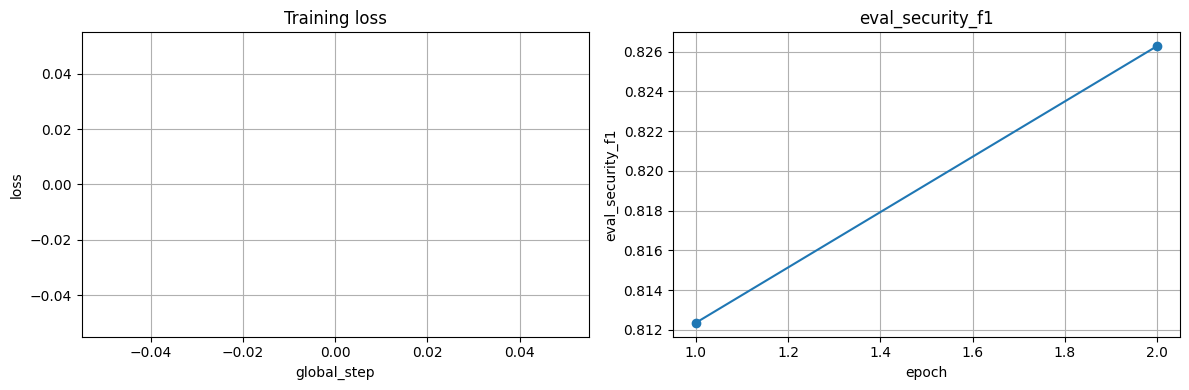

RuntimeError: [enforce fail at inline_container.cc:659] . unexpected pos 472459840 vs 472459728

In [8]:
#*** Carga dataset tokenizado y fine-tuning supervisado de DistilRoBERTa (binario 0/1) ***#
from pathlib import Path
import json, sys
import numpy as np
import torch
import torch.nn as nn
from datasets import load_from_disk

# Asegura que no quede una versión previa de transformers en memoria
sys.modules.pop("transformers", None)

import transformers  # import base primero para fijar versión en sys.modules
print("Transformers version:", transformers.__version__)

from transformers import (
    AutoTokenizer, AutoConfig, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding, set_seed
)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Directorio de salida (volumen persistente montado por Docker)
#OUT_DIR = "/checkpoints/run_distilroberta" -> Ya se define en bootstrap

# Localiza los artifacts
# Reutiliza BASE_ARTI definido en la celda anterior; si no, usa ruta del repo
if "BASE_ARTI" in globals():
    BASE_ARTI = Path(BASE_ARTI)
else:
    assert 'DEST' in globals(), "Ejecuta la celda Bootstrap para definir DEST."
    BASE_ARTI = DEST / "src" / "artifacts" / "hf_distilroberta"

# Si hubo anidamiento tipo hf_distilroberta/hf_distilroberta, corrige
if not (BASE_ARTI / "dataset").exists() and (BASE_ARTI / "hf_distilroberta").exists():
    BASE_ARTI = BASE_ARTI / "hf_distilroberta"

assert (BASE_ARTI / "dataset").exists() and (BASE_ARTI / "tokenizer").exists(), \
    f"Faltan dataset/ o tokenizer/ en {BASE_ARTI}. Revisa la celda de preparación de artifacts."
print("OK artifacts:", BASE_ARTI)

# Dispositivo y GPU info (ROCm)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("GPU disponible:", torch.cuda.is_available(), "| HIP:", getattr(torch.version, "hip", None))
if torch.cuda.is_available():
    print("Device 0:", torch.cuda.get_device_name(0))

set_seed(42)

# --- PARCHE ROBUSTO V2 para carga desde disk con datasets==4.x ---
# Idempotente y sin recursión. Evita fallos al reconstruir `features` de DatasetInfo.
import datasets

DI = datasets.info.DatasetInfo
Feat = datasets.Features

# 1) Parchea from_dict una sola vez: si las features del JSON fallan, las ignora (None)
if not hasattr(DI, "_orig_from_dict"):
    DI._orig_from_dict = DI.from_dict

    @classmethod
    def _safe_from_dict(cls, dataset_info_dict: dict):
        try:
            return cls._orig_from_dict(dataset_info_dict)
        except Exception as e:
            dd = dict(dataset_info_dict or {})
            if "features" in dd:
                dd["features"] = None
            obj = cls._orig_from_dict(dd)
            print("[patch] DatasetInfo.from_dict: ignorando 'features' corruptas -> usando None.", f"({type(e).__name__})")
            return obj

    DI.from_dict = _safe_from_dict

# 2) Sustituye __post_init__ por una versión NO recursiva y segura (una sola vez)
if not hasattr(DI, "_post_init_patched"):
    def _safe_post_init(self):
        try:
            f = getattr(self, "features", None)
            if f is not None and not isinstance(f, Feat):
                try:
                    self.features = Feat.from_dict(f)
                except Exception:
                    self.features = None
        except Exception:
            self.features = None
        # No llamamos al __post_init__ original

    DI.__post_init__ = _safe_post_init
    DI._post_init_patched = True
# --- FIN PARCHE ROBUSTO V2 ---

# dataset/tokenizer
ds  = load_from_disk(str(BASE_ARTI / "dataset"))

## Comprobación de splits + fallback opcional
print("Splits disponibles:", list(ds.keys()))
needed = {"train", "validation", "test"}
avail = set(ds.keys())

## Si por accidente el split se llama "dev", lo renombramos a "validation"
if "validation" not in avail and "dev" in avail:
    ds["validation"] = ds["dev"]
    del ds["dev"]
    avail = set(ds.keys())
    print("Renombrado 'dev' -> 'validation'")

## Si faltan splits, corta con mensaje claro
missing = needed - avail
assert not missing, f"Faltan splits: {missing}. Revisa el paso de tokenización/guardado."

tok = AutoTokenizer.from_pretrained(str(BASE_ARTI / "tokenizer"), use_fast=True)

# === Multiclase: lee mapping real desde preprocess_meta.json
meta = json.loads((BASE_ARTI / "preprocess_meta.json").read_text())
label2id = {k:int(v) for k,v in meta["label_to_id"].items()}
id2label = {int(k):v for k,v in meta["id_to_label"].items()}
num_labels = len(label2id)  # 3 clases: bug/other/security
SEC_ID = label2id.get("security", 2)

# Unificar columna y tipar labels a enteros
from datasets import ClassLabel

# 1) Renombra si viniera como "label"
if "label" in ds["train"].column_names and "labels" not in ds["train"].column_names:
    ds = ds.rename_column("label", "labels")

# 2) Mapea strings -> ids o fuerza a int si ya vinieran numéricas
def _labels_to_ids(batch):
    vals = batch["labels"]
    if isinstance(vals[0], str):
        batch["labels"] = [label2id[v] for v in vals]
    else:
        batch["labels"] = [int(v) for v in vals]
    return batch

ds = ds.map(_labels_to_ids, batched=True)

# 3) (Opcional pero recomendable) Fijar esquema explícito con nombres
label_names = [id2label[i] for i in range(num_labels)]
ds = ds.cast_column("labels", ClassLabel(num_classes=num_labels, names=label_names))

print(ds["train"].features)


# métricas macro + foco en "security vs resto"
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    acc = accuracy_score(labels, preds)
    p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(
        labels, preds, average="macro", zero_division=0
    )
    y_true_sec = (labels == SEC_ID).astype(int)
    y_pred_sec = (preds  == SEC_ID).astype(int)
    p_sec, r_sec, f1_sec, _ = precision_recall_fscore_support(
        y_true_sec, y_pred_sec, average="binary", zero_division=0
    )
    
    return {
        "accuracy": acc,
        "macro_precision": p_macro, "macro_recall": r_macro, "macro_f1": f1_macro,
        "security_precision": p_sec, "security_recall": r_sec, "security_f1": f1_sec,
    }

# class weights (longitud = num_labels)
cw = None

if "class_weights" in meta and isinstance(meta["class_weights"], dict):
    cw_map = {int(k): float(v) for k, v in meta["class_weights"].items()}
    cw = np.array([cw_map.get(i, 1.0) for i in range(num_labels)], dtype=np.float32)
    print("Class weights:", cw.tolist())

# Comprobación de la ruta
import os
print("HF_HOME =", os.environ.get("HF_HOME"))
print("HUGGINGFACE_HUB_CACHE =", os.environ.get("HUGGINGFACE_HUB_CACHE"))
print("TRANSFORMERS_CACHE =", os.environ.get("TRANSFORMERS_CACHE"))
##

# Config para el modelo distilrobeta-base utilizando el mapeo real de labels disponible en preprocess_meta.json
config = AutoConfig.from_pretrained(
    "distilroberta-base",
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

model  = AutoModelForSequenceClassification.from_pretrained("distilroberta-base", config=config)

# Collator que ignora claves no usadas por el modelo y añade labels aparte
class SafeCollator(DataCollatorWithPadding):
    def __call__(self, features):
        # recoge labels (acepta 'labels' o 'label')
        labels = []
        cleaned = []
        for f in features:
            if "labels" in f:
                labels.append(f["labels"])
            elif "label" in f:
                labels.append(f["label"])
            # solo claves esperadas por el modelo
            nf = {}
            for k in ("input_ids", "attention_mask", "token_type_ids"):
                if k in f:
                    nf[k] = f[k]
            cleaned.append(nf)

        batch = self.tokenizer.pad(cleaned, padding=True, return_tensors="pt")
        if labels:
            batch["labels"] = torch.tensor(labels, dtype=torch.long)
        return batch

collator = SafeCollator(tokenizer=tok, return_tensors="pt")

# Trainer con pérdida ponderada (si hay weights) y filtrado de inputs
class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = (
            torch.tensor(class_weights, dtype=torch.float32) if class_weights is not None else None
        )

    # En Transformers 4.56.x, Trainer pasa num_items_in_batch; lo aceptamos e ignoramos.
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        # Acepta 'labels' o 'label'
        labels = inputs.pop("labels", None)
        if labels is None and "label" in inputs:
            labels = inputs.pop("label")
        if labels is None:
            raise ValueError("Missing 'labels' in inputs")

        # Filtra claves inesperadas (evita pasar id/context_id al modelo)
        allowed = {"input_ids", "attention_mask", "token_type_ids"}
        model_inputs = {k: v for k, v in inputs.items() if k in allowed}

        outputs = model(**model_inputs)
        logits = outputs.logits  # [B, 2]

        # CrossEntropy con o sin pesos
        if self.class_weights is not None:
            loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        else:
            loss_fct = nn.CrossEntropyLoss()

        loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1).long())
        return (loss, outputs) if return_outputs else loss

# --- TrainingArguments (compatible 4.x) ---
from inspect import signature

TA = TrainingArguments
ta_params = set(signature(TA).parameters.keys())

# Compat: algunas versiones usan 'eval_strategy' en vez de 'evaluation_strategy'
has_evaluation_strategy = "evaluation_strategy" in ta_params
has_eval_strategy = "eval_strategy" in ta_params

# 'report_to' en versiones recientes debe ser lista (no string)
report_to_val = []  # equivalente a "none"

# Mezcla de precisión óptima en ROCm (usa bf16 si está soportado, si no fp16)
use_bf16 = torch.cuda.is_available() and torch.cuda.is_bf16_supported()
use_fp16 = torch.cuda.is_available() and not use_bf16

# Opcional: algo de ahorro de VRAM con gradient checkpointing
# (si notas el entrenamiento muy justo de VRAM, ponlo a True)
gradient_checkpointing = False

# Algo de rendimiento en matmul (no afecta a la reproducibilidad exacta)
try:
    torch.set_float32_matmul_precision("high")
except Exception:
    pass


ta_kwargs = dict(
    output_dir=OUT_DIR,
    # Logging/eval/guardar por época: suficiente para tu workflow y ligero
    save_strategy="epoch",
    #evaluation_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,

    # Núcleo de entrenamiento
    per_device_train_batch_size=16,   # efectivo 32 con grad_accum, ver abajo
    per_device_eval_batch_size=32,    # eval cabe bien con 16 GB VRAM
    gradient_accumulation_steps=2,    # efectivo 32 -> estable y rápido
    num_train_epochs=3,               # sube a 4 si quieres exprimir un poco más
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    max_grad_norm=1.0,

    # Precisión mixta en ROCm
    bf16=use_bf16,
    fp16=use_fp16,

    # Optimizador/planificador robustos
    optim="adamw_torch",
    lr_scheduler_type="cosine",       # suave; alternativa: "linear"

    # Rendimiento DataLoader
    dataloader_num_workers=4,         # súbelo a 6–8 si el disco da de sí
    dataloader_pin_memory=True,

    # Infra de Trainer
    report_to=report_to_val,
    remove_unused_columns=False,      # mantenemos id/context_id
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="security_f1",   #<-------- o "security_f1" si prefiero
    greater_is_better=True,
    seed=42,

    # Compilación desactivada por defecto (a veces inestable en ROCm)
    torch_compile=False,

    #Si se queda corto/largo de VRAM (OOM/sobra)
    #OOM: baja per_device_train_batch_size a 12 o 8; o pon gradient_checkpointing=True (más lento pero ahorra VRAM).
    #Sobra VRAM y quieres apretar: sube per_device_train_batch_size a 20–24 y baja gradient_accumulation_steps a 1 (o mantén 2 para más estabilidad).
)

# Añade la estrategia de evaluación usando el nombre correcto
if has_evaluation_strategy:
    ta_kwargs["evaluation_strategy"] = "epoch"
elif has_eval_strategy:
    ta_kwargs["eval_strategy"] = "epoch"
else:
    print("[warn] TrainingArguments no tiene evaluation_strategy/​eval_strategy; se usará la predeterminada.")

# Activa gradient checkpointing si lo pediste arriba
if gradient_checkpointing:
    model.gradient_checkpointing_enable()

args = TA(**ta_kwargs)

from transformers import EarlyStoppingCallback
trainer = WeightedTrainer(
    class_weights=cw,
    model=model, args=args,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    processing_class=tok,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[live_cb, EarlyStoppingCallback(early_stopping_patience=2)],
)

trainer.train()

print("\n== Eval (validation) justo tras entrenamiento ==")
metrics_val = trainer.evaluate(eval_dataset=ds["validation"])
for k, v in metrics_val.items():
    print(f"{k}: {v:.4f}" if isinstance(v, (int, float)) else f"{k}: {v}")


trainer.save_model(str(SAVE_DIR))
tok.save_pretrained(str(SAVE_DIR))
print("Modelo guardado en:", SAVE_DIR)

# === Post-entrenamiento: curvas desde logs ===

In [ ]:
# Curvas de entrenamiento SIN widgets (robusto en VS Code/ROCm)
# - Funciona aunque hayas reiniciado el kernel (lee trainer_state.json)
# - Guarda PNG y CSV con las métricas

import os, json, math
from pathlib import Path

# 0) Backend no interactivo *antes* de importar pyplot
import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pyplot as plt
from IPython.display import Image, display
import csv

# 1) Localiza OUT_DIR y trainer_state.json
assert 'OUT_DIR' in globals(), "OUT_DIR no está definido (ejecuta Bootstrap/entrenamiento)."
OUT_DIR = Path(OUT_DIR)
ts_path = OUT_DIR / "trainer_state.json"

# 2) Cargar log_history (memoria o disco)
log_history = []
if 'trainer' in globals() and hasattr(trainer, 'state') and trainer.state.log_history:
    log_history = trainer.state.log_history

if (not log_history) and ts_path.exists():
    with ts_path.open("r", encoding="utf-8") as f:
        ts = json.load(f)
    log_history = ts.get("log_history", [])

print(f"log_history registros: {len(log_history)}")
if not log_history:
    print(f"⚠️ No hay logs. ¿Se ejecutó entrenamiento? Revisar {ts_path}")

# 3) Extraer series
steps, tr_loss = [], []
epx, eval_f1, eval_prec, eval_rec, eval_acc = [], [], [], [], []
lrs, lr_steps = [], []

for e in log_history:
    # loss por step (solo si se configuró logging por pasos)
    if "loss" in e and "step" in e:
        steps.append(e["step"])
        tr_loss.append(e["loss"])
    # lr scheduler (si se logueó)
    if "learning_rate" in e and "step" in e:
        lr_steps.append(e["step"])
        lrs.append(e["learning_rate"])
    # métricas de validación por epoch
    if "eval_macro_f1" in e:
        ep = e.get("epoch")
        if ep is None:
            ep = (epx[-1] + 1) if epx else 1
        ep = int(ep) if isinstance(ep, (int, float)) and not math.isnan(ep) else ep
        epx.append(ep)
        eval_f1.append(e["eval_macro_f1"])
        #eval_prec.append(e.get("eval_precision", float("nan")))
        #eval_rec.append(e.get("eval_recall", float("nan")))
        #eval_acc.append(e.get("eval_accuracy", float("nan")))

# 4) Dibujar y guardar PNG
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# (A) Training loss
axs[0].plot(steps, tr_loss, marker=".", linestyle="-")
axs[0].set_title("Training loss (logs)")
axs[0].set_xlabel("global_step"); axs[0].set_ylabel("loss")
if not steps:
    axs[0].text(0.5, 0.5, "Sin logs por pasos.\nUsa logging_strategy='steps' y logging_steps.",
                ha="center", va="center", transform=axs[0].transAxes)

# (B) Métricas de validación por epoch
axs[1].plot(epx, eval_f1,   marker="o", label="F1")
axs[1].plot(epx, eval_prec, marker="o", label="Precision")
axs[1].plot(epx, eval_rec,  marker="o", label="Recall")
axs[1].plot(epx, eval_acc,  marker="o", label="Accuracy")
axs[1].set_title("Métricas de validación por época")
axs[1].set_xlabel("epoch"); axs[1].legend()
if not epx:
    axs[1].text(0.5, 0.5, "Sin métricas de validación.\n¿evaluation_strategy='epoch'?",
                ha="center", va="center", transform=axs[1].transAxes)

plt.tight_layout()

# 5) Salvar figuras/CSV en el repo
FIG_DIR = Path.cwd() / "figs"
FIG_DIR.mkdir(parents=True, exist_ok=True)
png_path = FIG_DIR / "training_curves.png"
plt.savefig(png_path, dpi=150, bbox_inches="tight")
plt.close(fig)

# CSV con métricas por epoch (si existen)
csv_path = FIG_DIR / "validation_metrics_by_epoch.csv"
if epx:
    with csv_path.open("w", newline="", encoding="utf-8") as f:
        w = csv.writer(f)
        w.writerow(["epoch", "f1", "precision", "recall", "accuracy"])
        for i in range(len(epx)):
            w.writerow([epx[i], eval_f1[i], eval_prec[i], eval_rec[i], eval_acc[i]])

print("Figura guardada en:", png_path)
if epx:
    print("CSV guardado en:", csv_path)

display(Image(filename=str(png_path)))


## Calibración autónoma desde disco (sin reentrenar)

In [ ]:
from pathlib import Path
import json, numpy as np, torch
from datasets import load_from_disk
from transformers import (AutoTokenizer, AutoConfig, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer, DataCollatorWithPadding)

# RUTAS (locales)
if "BASE_ARTI" in globals():
    BASE_ARTI = Path(BASE_ARTI)
else:
    assert 'DEST' in globals(), "Ejecuta la celda Bootstrap para definir DEST."
    BASE_ARTI = DEST / "src" / "artifacts" / "hf_distilroberta"

OUT_TMP  = (DEST / "tmp_calib"); OUT_TMP.mkdir(parents=True, exist_ok=True)

# 1) Dataset y tokenizer
ds  = load_from_disk(str(BASE_ARTI / "dataset"))
tok = AutoTokenizer.from_pretrained(str(BASE_ARTI / "tokenizer"), use_fast=True)

# 2) Modelo (final)
config = AutoConfig.from_pretrained(str(SAVE_DIR))
model  = AutoModelForSequenceClassification.from_pretrained(str(SAVE_DIR), config=config)

# 3) Trainer “ligero” solo para predict
args = TrainingArguments(
    output_dir=str(OUT_TMP),
    per_device_eval_batch_size=128,
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=2,
    report_to=[]
)
trainer = Trainer(
    model=model, args=args, processing_class=tok,
    data_collator=DataCollatorWithPadding(tokenizer=tok, return_tensors="pt")
)

# --- Calibración rápida (un único predict) ---
def _prepare_pred_dataset(split):
    d = ds[split]
    cols = d.column_names
    label_col = "labels" if "labels" in cols else ("label" if "label" in cols else None)
    assert label_col is not None, f"Split {split} sin columna de label."
    keep = ["input_ids", "attention_mask", label_col] + (["token_type_ids"] if "token_type_ids" in cols else [])
    ids = d["id"] if "id" in cols else list(range(len(d)))
    ctx = d["context_id"] if "context_id" in cols else [0] * len(d)
    pred_ds = d.remove_columns([c for c in cols if c not in keep])
    labels = np.array(d[label_col])
    return pred_ds, labels, np.array(ids), np.array(ctx)

def logits_labels_ids(split):
    pred_ds, labels, ids, ctx = _prepare_pred_dataset(split)
    logits = trainer.predict(pred_ds).predictions  # [N, 2]
    return logits, labels, ids, ctx

def softmax_np(x):
    x = x - x.max(axis=-1, keepdims=True)
    ex = np.exp(x)
    return ex / ex.sum(axis=-1, keepdims=True)

logits_val, labels_val, ids_val, ctx_val = logits_labels_ids("validation")
# ➜ probabilidad de "security"
p1_val = softmax_np(logits_val)[:, SEC_ID]

# Pooling máximo por comentario (id, context_id)
keys = np.core.defchararray.add(ids_val.astype(str), "::" + ctx_val.astype(str))
order = np.argsort(keys)
keys_s, p1_s, y_s = keys[order], p1_val[order], labels_val[order]
grp_st = np.r_[0, 1 + np.flatnonzero(keys_s[1:] != keys_s[:-1])]
pooled_p1 = np.maximum.reduceat(p1_s, grp_st)
pooled_y  = y_s[grp_st].astype(int)

TARGET_PREC = 0.95  # objetivo de precisión mínima -> menos falsos positivos
# Busca el mejor umbral que maximice recall con precision >= TARGET_PREC
ord_desc = np.argsort(-pooled_p1)
scores = pooled_p1[ord_desc]
y_true = pooled_y[ord_desc]
tp = np.cumsum(y_true); fp = np.cumsum(1 - y_true); fn_tot = y_true.sum()
prec = tp / np.maximum(tp + fp, 1e-9)
rec  = tp / np.maximum(fn_tot, 1e-9)
mask = prec >= TARGET_PREC
best_idx = int(np.argmax(rec * mask)) if np.any(mask) else int(np.argmax(prec))
best_thr, best_prec, best_rec = float(scores[best_idx]), float(prec[best_idx]), float(rec[best_idx])

(SAVE_DIR / "threshold.json").write_text(json.dumps({
    "threshold": best_thr,
    "target_precision": TARGET_PREC,
    "precision_at_threshold": best_prec,
    "recall_at_threshold": best_rec
}, indent=2), encoding="utf-8")

print(f"[calibración] threshold={best_thr:.4f} | precision={best_prec:.4f} | recall={best_rec:.4f}")

# === Visualización de calibración (usar variables ya calculadas) ===
Muestra la curva PR y la distribución de puntuaciones por clase (válido para la memoria del TFG). Además guarda `val_pooled_scores.npy` y `val_pooled_labels.npy` en SAVE_DIR por si se necesita "replotear".

In [ ]:
# Guardado para reutilizar en otra sesión
np.save(Path(SAVE_DIR, "val_pooled_scores.npy"), scores)     # prob. clase 1 por comentario
np.save(Path(SAVE_DIR, "val_pooled_labels.npy"), y_true.astype(int))

# Curva Prec-Recall (ordenando por score desc, ya lo tenemos)
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(rec, prec)
plt.scatter([best_rec], [best_prec], marker="o", label=f"thr={best_thr:.3f}")
plt.title("Precision-Recall (validación, pooling=max)")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend(); plt.grid(True)
plt.show()

# Histograma de puntuaciones
plt.figure(figsize=(6,4))
plt.hist(scores[y_true==0], bins=30, alpha=0.6, label="negativos")
plt.hist(scores[y_true==1], bins=30, alpha=0.6, label="positivos")
plt.axvline(best_thr, ls="--", label=f"threshold={best_thr:.3f}")
plt.title("Distribución de puntuaciones (pooled p1)")
plt.xlabel("p1 (pooled)"); plt.ylabel("count"); plt.legend(); plt.grid(True)
plt.show()


In [ ]:
## Evaluación final en TEST (pooling por comentario)
import json, numpy as np, torch
from pathlib import Path
from datasets import load_from_disk
from transformers import (AutoTokenizer, AutoConfig, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer, DataCollatorWithPadding)

# Rutas
if "BASE_ARTI" in globals():
    BASE_ARTI = Path(BASE_ARTI)
else:
    assert 'DEST' in globals(), "Ejecuta la celda Bootstrap para definir DEST."
    BASE_ARTI = DEST / "src" / "artifacts" / "hf_distilroberta"

thr = float(json.loads((SAVE_DIR / "threshold.json").read_text())["threshold"])

# Carga
ds  = load_from_disk(str(BASE_ARTI / "dataset"))
tok = AutoTokenizer.from_pretrained(str(BASE_ARTI / "tokenizer"), use_fast=True)
config = AutoConfig.from_pretrained(str(SAVE_DIR))
model  = AutoModelForSequenceClassification.from_pretrained(str(SAVE_DIR), config=config)

args = TrainingArguments(
    output_dir=str(DEST / "tmp_eval"),
    per_device_eval_batch_size=128,
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=2,
    report_to=[]
)
trainer = Trainer(
    model=model, args=args, processing_class=tok,
    data_collator=DataCollatorWithPadding(tokenizer=tok, return_tensors="pt")
)

def _prep(split):
    d = ds[split]; cols = d.column_names
    label_col = "labels" if "labels" in cols else "label"
    keep = ["input_ids","attention_mask",label_col] + (["token_type_ids"] if "token_type_ids" in cols else [])
    ids = d["id"] if "id" in cols else list(range(len(d)))
    ctx = d["context_id"] if "context_id" in cols else [0]*len(d)
    pred_ds = d.remove_columns([c for c in cols if c not in keep])
    labels = np.array(d[label_col])
    return pred_ds, labels, np.array(ids), np.array(ctx)

def _softmax(x): x=x-x.max(axis=-1,keepdims=True); ex=np.exp(x); return ex/ex.sum(axis=-1,keepdims=True)

def _pooled(split):
    pred_ds, labels, ids, ctx = _prep(split)
    logits = trainer.predict(pred_ds).predictions
    p1 = _softmax(logits)[:, SEC_ID]
    keys = np.core.defchararray.add(ids.astype(str),"::"+ctx.astype(str))
    order = np.argsort(keys); keys_s,p1_s,y_s = keys[order],p1[order],labels[order]
    grp = np.r_[0,1+np.flatnonzero(keys_s[1:]!=keys_s[:-1])]
    pooled_p1 = np.maximum.reduceat(p1_s, grp)
    pooled_y  = y_s[grp].astype(int)
    return pooled_p1, pooled_y

def _metrics(split, thr):
    scores, y_true = _pooled(split)
    pred = (scores >= thr).astype(int)
    tp = int(((pred==1)&(y_true==1)).sum())
    fp = int(((pred==1)&(y_true==0)).sum())
    fn = int(((pred==0)&(y_true==1)).sum())
    tn = int(((pred==0)&(y_true==0)).sum())
    prec = tp / max(tp+fp, 1e-9)
    rec  = tp / max(tp+fn, 1e-9)
    f1   = 2*prec*rec / max(prec+rec, 1e-9)
    acc  = (tp+tn) / max(tp+tn+fp+fn, 1e-9)
    return dict(precision=prec, recall=rec, f1=f1, accuracy=acc,
                counts=dict(tp=tp, fp=fp, fn=fn, tn=tn))

val_metrics  = _metrics("validation", thr)
test_metrics = _metrics("test", thr)

(SAVE_DIR / "eval_comment_level.json").write_text(
    json.dumps({"validation": val_metrics, "test": test_metrics}, indent=2), encoding="utf-8"
)
(SAVE_DIR / "inference_meta.json").write_text(
    json.dumps({"pooling":"max", "threshold": float(thr)}, indent=2), encoding="utf-8"
)

print("VAL:", val_metrics)
print("TEST:", test_metrics)
print("Guardado en:", SAVE_DIR)

# === Matriz de confusión (valid/test) ===

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion(cm, title):
    plt.figure(figsize=(4,4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.xticks([0,1], ["Pred 0","Pred 1"])
    plt.yticks([0,1], ["True 0","True 1"])
    for (i,j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center", color="white" if v>cm.max()/2 else "black")
    plt.colorbar(); plt.tight_layout(); plt.show()

cm_val = np.array([[val_metrics["counts"]["tn"], val_metrics["counts"]["fp"]],
                   [val_metrics["counts"]["fn"], val_metrics["counts"]["tp"]]])
cm_tst = np.array([[test_metrics["counts"]["tn"], test_metrics["counts"]["fp"]],
                   [test_metrics["counts"]["fn"], test_metrics["counts"]["tp"]]])

plot_confusion(cm_val, "Confusion Matrix (VALID)")
plot_confusion(cm_tst, "Confusion Matrix (TEST)")


In [ ]:
## "Pack" final listo para reutilizar/re-entrenar (en el propio repo)
import shutil
from pathlib import Path

DEPLOY_DIR = DEST / "deploy_distilroberta"
if DEPLOY_DIR.exists():
    shutil.rmtree(DEPLOY_DIR)
shutil.copytree(SAVE_DIR, DEPLOY_DIR)
print("Pack listo en:", DEPLOY_DIR)
print("Contenidos:", [p.name for p in DEPLOY_DIR.iterdir()])